In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from datasets import *
import matplotlib.pyplot as plt
import cv2
from keras.datasets import mnist
import tensorflow as tf
import numpy as np
from random import randint
import keras
import keras.backend as K
from keras.models import Model, Sequential
from keras.layers.merge import Concatenate
from keras.layers import Input, Reshape, Dense, Conv2D, Dropout, \
    MaxPooling2D, Flatten, UpSampling2D, Multiply, Activation, AveragePooling2D, \
    Add, Subtract, Lambda
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, TensorBoard
from scipy.ndimage import gaussian_filter as blur
from keras.optimizers import Adam
from keras.utils import multi_gpu_model as mgpu
from keras.utils import np_utils
import os, sys

Using TensorFlow backend.


In [2]:
from models.gap_mask import gap_mask

model = gap_mask(imsize=256)

 [!] Conv Spec:
 [!] 256 => 128: [64, 128]
 [!] 128 => 64: [256, 256, 256, 256]
 [!] 64 => 32: [256, 256, 256, 256]
 [!] 32 => 16: [512, 512, 512, 512]
 [!] 16 => 8: [512, 512, 512, 512]
 [!] 8 => 8: [512, 512, 512, 512]
 [!] 8 => 8: [1024, 1024, 2048, 2048]


In [3]:
print(model.count_params())
model.compile()

149.7 million


In [4]:
dset = Tissue()

 [*] tissue_sick: 2162 unique cases (2162 total)
 [*] tissue_healthy: 2951 unique cases (278564 total)
 [*] tissue_sick: 1650 / 512
 [*] tissue_healthy: 229652 / 48912


In [5]:
samplegen = dset.gen(bsize=8, regionsize=8, labels=['regions', 'lbls', 'refs'])

In [6]:
imgs, (regions, lbls), refs = next(samplegen)

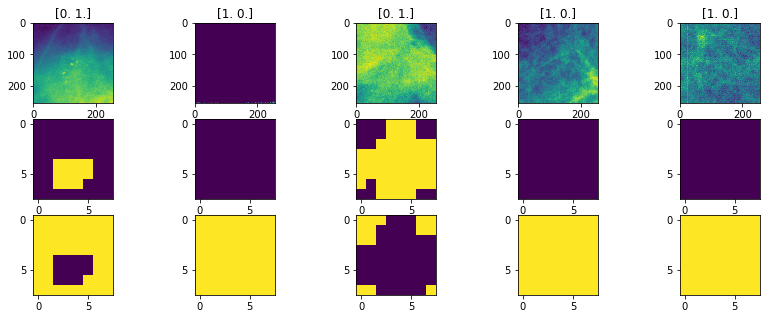

In [7]:
plt.figure(figsize=(14, 5))
for ii in range(5):
    plt.subplot(3, 5, ii+1)
    plt.gca().set_title(lbls[ii])
    plt.imshow(imgs[ii, :, :, 0])
    plt.subplot(3, 5, 5+ii+1)
    plt.imshow(regions[ii, :, :, 1])
    plt.subplot(3, 5, 5*2+ii+1)
    plt.imshow(regions[ii, :, :, 0], vmin=0, vmax=1)
plt.show()
plt.close()

In [8]:
counter = 0
class Checkpoint(keras.callbacks.Callback):
    def __init__(self, evalset):
        self.evalset = evalset
        _, (_, _), refs = self.evalset
        print('Preview set:')
        for ii in range(7):
            print('  %s' % refs[ii].split('/')[-1])
        
    def on_batch_begin(self, batch, logs={}):
        global counter
        if counter % 200 == 0:
            if counter != 0:
                model.save() # save after first interval
            
            imgs, (regions, lbls), refs = self.evalset
            rpnout, yout = model.model.predict(imgs)

            imgs, (regions, lbls), refs = self.evalset

            plt.figure(figsize=(14, 4))
            for ii in range(7): # preview 7 images
                plt.subplot(3, 7, ii+1)
                plt.axis('off')
                plt.gca().set_title(lbls[ii])
                plt.imshow(imgs[ii, :, :, 0])

                plt.subplot(3, 7, 7+ii+1)
                plt.axis('off')
                plt.imshow(regions[ii, :, :, 1], vmin=0, vmax=1)
                
                plt.subplot(3, 7, 14+ii+1)
                plt.axis('off')
                plt.gca().set_title('%.2f' % yout[ii, 1])
                plt.imshow(rpnout[ii, :, :, 1], vmin=0, vmax=1)
            plt.show()
            plt.close()
        counter += 1
        return

Preview set:
  01684_LEFT_CC.npy
  00879_RIGHT_MLO.npy
  01243_LEFT_MLO.npy
  01642_RIGHT_CC.npy
  01045_RIGHT_MLO.npy
  00621_LEFT_CC.npy
  00593_RIGHT_CC.npy
Epoch 1/12


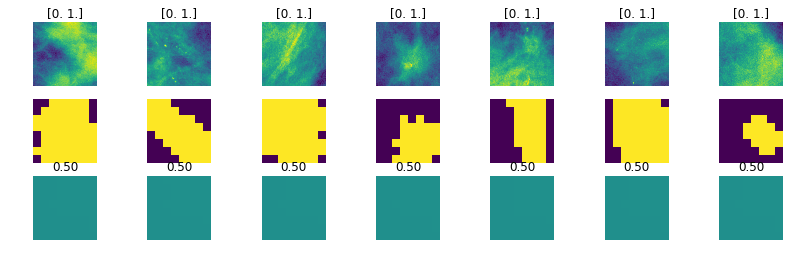

200/290 [===================>..........] - ETA: 3:00 - loss: 0.6298 - rpn_loss: -0.0330 - yhat_loss: 0.6628 - rpn_outer_penalty: 0.0847 - yhat_acc: 0.6921

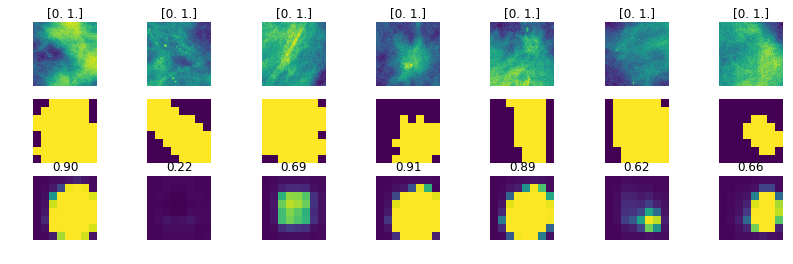

290/290 [==============================] - 576s 2s/step - loss: 0.5661 - rpn_loss: -0.0462 - yhat_loss: 0.6122 - rpn_outer_penalty: 0.0774 - yhat_acc: 0.7147 - val_loss: 0.5550 - val_rpn_loss: 0.0071 - val_yhat_loss: 0.5479 - val_rpn_outer_penalty: 0.1483 - val_yhat_acc: 0.8214
Epoch 2/12
110/290 [==========>...................] - ETA: 5:29 - loss: 0.3880 - rpn_loss: -0.0889 - yhat_loss: 0.4769 - rpn_outer_penalty: 0.0569 - yhat_acc: 0.7737

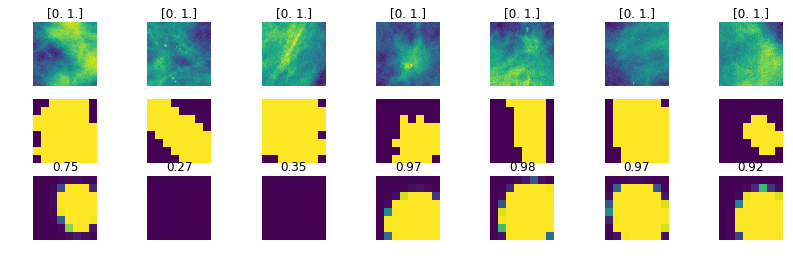

290/290 [==============================] - 458s 2s/step - loss: 0.3763 - rpn_loss: -0.0866 - yhat_loss: 0.4629 - rpn_outer_penalty: 0.0582 - yhat_acc: 0.7823 - val_loss: 0.2779 - val_rpn_loss: -0.0635 - val_yhat_loss: 0.3413 - val_rpn_outer_penalty: 0.1055 - val_yhat_acc: 0.8214
Epoch 3/12
 20/290 [=>............................] - ETA: 5:54 - loss: 0.3795 - rpn_loss: -0.0794 - yhat_loss: 0.4590 - rpn_outer_penalty: 0.0720 - yhat_acc: 0.7714

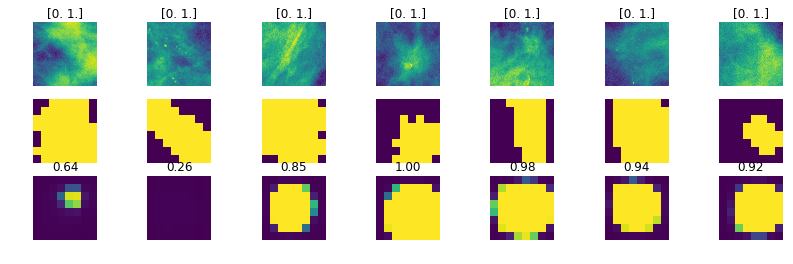

220/290 [=====================>........] - ETA: 1:30 - loss: 0.3362 - rpn_loss: -0.0878 - yhat_loss: 0.4240 - rpn_outer_penalty: 0.0603 - yhat_acc: 0.8036

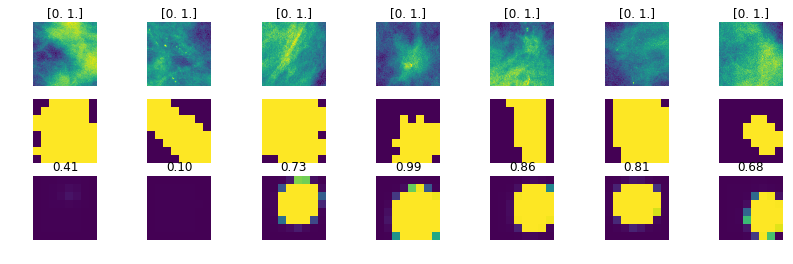

290/290 [==============================] - 369s 1s/step - loss: 0.3322 - rpn_loss: -0.0891 - yhat_loss: 0.4213 - rpn_outer_penalty: 0.0612 - yhat_acc: 0.8083 - val_loss: 0.8310 - val_rpn_loss: -0.0662 - val_yhat_loss: 0.8972 - val_rpn_outer_penalty: 0.0939 - val_yhat_acc: 0.8929
Epoch 4/12
130/290 [============>.................] - ETA: 3:05 - loss: 0.2962 - rpn_loss: -0.0961 - yhat_loss: 0.3923 - rpn_outer_penalty: 0.0567 - yhat_acc: 0.8266

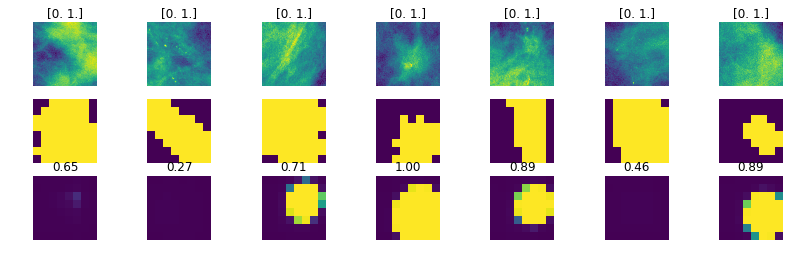

290/290 [==============================] - 343s 1s/step - loss: 0.2886 - rpn_loss: -0.0978 - yhat_loss: 0.3864 - rpn_outer_penalty: 0.0608 - yhat_acc: 0.8350 - val_loss: 0.2814 - val_rpn_loss: -0.0999 - val_yhat_loss: 0.3813 - val_rpn_outer_penalty: 0.0652 - val_yhat_acc: 0.8571
Epoch 5/12
 40/290 [===>..........................] - ETA: 4:51 - loss: 0.3135 - rpn_loss: -0.0959 - yhat_loss: 0.4094 - rpn_outer_penalty: 0.0586 - yhat_acc: 0.8179

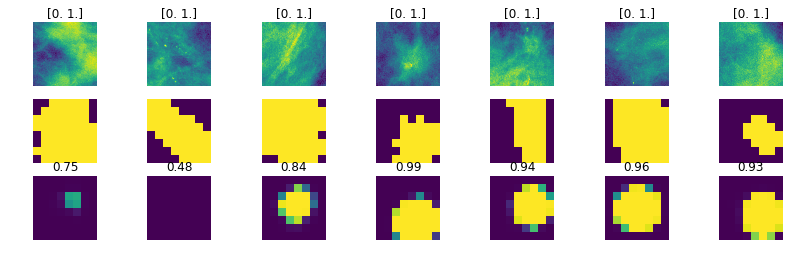

240/290 [=======================>......] - ETA: 1:10 - loss: 0.2817 - rpn_loss: -0.0982 - yhat_loss: 0.3799 - rpn_outer_penalty: 0.0618 - yhat_acc: 0.8388

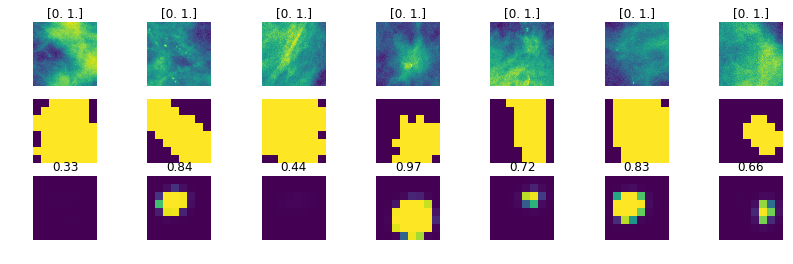

290/290 [==============================] - 427s 1s/step - loss: 0.2905 - rpn_loss: -0.0966 - yhat_loss: 0.3871 - rpn_outer_penalty: 0.0621 - yhat_acc: 0.8378 - val_loss: 1.7036 - val_rpn_loss: -0.1149 - val_yhat_loss: 1.8185 - val_rpn_outer_penalty: 0.0572 - val_yhat_acc: 0.8929
Epoch 6/12
118/290 [===========>..................] - ETA: 5:00 - loss: 0.3129 - rpn_loss: -0.0980 - yhat_loss: 0.4109 - rpn_outer_penalty: 0.0596 - yhat_acc: 0.8211

In [ ]:
bsize = 28

previewset = next(dset.gen(
    bsize=bsize, mode='test', regionsize=8, labels=['regions', 'lbls', 'refs'], sickonly=True))
datagen = dset.gen(bsize=bsize, regionsize=8, labels=['regions', 'lbls'])
evalgen = dset.gen(bsize=bsize, mode='test', regionsize=8, labels=['regions', 'lbls'])

model.model.fit_generator(
    datagen,
    epochs=12,
    verbose=1,
    steps_per_epoch=dset.train_size // bsize * 5, # do x10 to experience many augmentations
    
    validation_data=evalgen,
    validation_steps=dset.test_size // bsize // 10, # just do 10th of val data
    
    callbacks=[Checkpoint(previewset)]
)


In [ ]:
## preds, yguess = model.model.predict(imgs)

In [ ]:
plt.figure(figsize=(14, 7))
for ii in range(5):
    plt.subplot(4, 5, ii+1)
    plt.gca().set_title(lbls[ii])
    plt.imshow(imgs[ii, :, :, 0])
    plt.subplot(4, 5, 5+ii+1)
    plt.gca().set_title(np.argmax(yguess[ii]))
    plt.imshow(preds[ii, :, :, 1], vmin=0, vmax=1)
    plt.subplot(4, 5, 5*2+ii+1)
    plt.imshow(preds[ii, :, :, 0], vmin=0, vmax=1)
    plt.subplot(4, 5, 5*3+ii+1)
    plt.imshow(regions[ii, :, :, 1], vmin=0, vmax=1)
plt.show()
plt.close()
for ii in range(5):
    print(refs[ii])

In [ ]:
from utils import *

plot_raw('00468_LEFT_CC')

In [ ]:
plt.figure(figsize=(14, 7))
for ii in range(5):
    plt.subplot(3, 5, ii+1)
    plt.axis('off')
    plt.gca().set_title(lbls[ii])
    plt.imshow(imgs[ii, :, :, 0])
    
    plt.subplot(3, 5, 5*1+ii+1)
    plt.axis('off')
    plt.gca().set_title('Mask Predicted')
    plt.imshow(imgs[ii, :, :, 0])
    large = cv2.resize(preds[ii, :, :, 1], (0,0), fx=32, fy=32)
    plt.imshow(large, vmin=0, vmax=1, alpha=0.5)
    
    plt.subplot(3, 5, 5*2+ii+1)
    plt.axis('off')
    plt.gca().set_title('Mask Given')
    plt.imshow(imgs[ii, :, :, 0])
    large = cv2.resize(regions[ii, :, :, 1], (0,0), fx=32, fy=32)
    plt.imshow(large, vmin=0, vmax=1, alpha=0.5)
plt.show()
plt.close()
for ii in range(5):
    print(refs[ii])

In [ ]:
_ = plot_raw('00468_LEFT_MLO')